In [1]:
import polars
import matplotlib.pyplot as plt
import torchaudio

import helpers.input_processor as ip

In [2]:
data_dir = "data/raw_training/training_data/"
df = ip.ingest_data(data_dir)

Reading from .txt files in data/raw_training/training_data/: 100%|██████████| 942/942 [00:00<00:00, 7817.28it/s]


In [3]:
# output metadata of first audio file
metadata = torchaudio.info(data_dir + df['audio_file'][0][0])
print(metadata)

AudioMetaData(sample_rate=4000, num_frames=41152, num_channels=1, bits_per_sample=16, encoding=PCM_S)


In [4]:
# loop through the dataset and create a list of audio paths
audioPaths = []
labels = []
for i in range(len(df)):
    for j in range(len(df['audio_file'][i])):
        audioPaths.append(data_dir + df['audio_file'][i][j])
        # check if there is a murmur at the recording location
        murmur = False
        for k in df['murmur_locations'][i]:
            if k in df['audio_file'][i][j]:
                labels.append(1)
                murmur = True
                break
        if murmur == False:
            labels.append(0)



print("Audio path number: ", len(audioPaths))
print("Label number: ", len(labels))

Audio path number:  3163
Label number:  3163


In [5]:
import random
import sys
import copy

# make the positive's and negative's equal
num_pos = 0
num_neg = 0

for i in range(len(labels)):

    if labels[i] == 1:
        num_pos += 1
    else:
        num_neg += 1

balanced_labels = copy.deepcopy(labels)
balanced_audio_paths = copy.deepcopy(audioPaths)


while num_pos != num_neg:
    # get ratio of positive to negative
    ratio = (num_pos / num_neg) * 100.0

    sys.stdout.flush()
    sys.stdout.write("\rRatio: %s" % ratio + "%")

    if num_pos > num_neg:
        foundNeg = False
        while foundNeg == False:
            idx = random.randint(0, len(balanced_labels) - 1)
            if balanced_labels[idx] == 0:
                balanced_labels.append(0)
                balanced_audio_paths.append(balanced_audio_paths[idx])
                foundNeg = True
                num_neg += 1
    else:
        foundPos = False
        while foundPos == False:
            idx = random.randint(0, len(balanced_labels) - 1)
            if balanced_labels[idx] == 1:
                balanced_labels.append(1)
                balanced_audio_paths.append(balanced_audio_paths[idx])
                foundPos = True
                num_pos += 1


Ratio: 99.96246246246247%%

In [6]:
# check how many positive and negative examples are in the dataset
num_pos = 0
num_neg = 0
for i in range(len(balanced_labels)):
    if balanced_labels[i] == 1:
        num_pos += 1
    else:
        num_neg += 1

print("Positive examples: ", num_pos)
print("Negative examples: ", num_neg)
print("Total examples: ", num_pos + num_neg)

print("Percentage of positive examples: ", (num_pos / (num_pos + num_neg)) * 100.0, "%")

Positive examples:  2664
Negative examples:  2664
Total examples:  5328
Percentage of positive examples:  50.0 %


In [12]:
# split audio paths and labels into training and testing sets shuffled
import random
zipped = list(zip(balanced_audio_paths, balanced_labels))
random.shuffle(zipped)
shuffled_audio_paths, shuffled_labels = zip(*zipped)

train_audio_paths = shuffled_audio_paths[:int(len(shuffled_audio_paths) * 0.8)]
train_labels = shuffled_labels[:int(len(shuffled_labels) * 0.8)]

test_audio_paths = shuffled_audio_paths[int(len(shuffled_audio_paths) * 0.8):]
test_labels = shuffled_labels[int(len(shuffled_labels) * 0.8):]

In [13]:
print("Training audio paths: ", len(train_audio_paths))
print("Training labels: ", len(train_labels))
print("Testing audio paths: ", len(test_audio_paths))
print("Testing labels: ", len(test_labels))

Training audio paths:  4262
Training labels:  4262
Testing audio paths:  1066
Testing labels:  1066


In [119]:
import numpy as np
import torch
import torchaudio

def batch_generator(image_paths, labels, batch_size):
    while True:
        for start in range(0, len(image_paths), batch_size):
            x_batch = []
            y_batch = []
            end = min(start + batch_size, len(image_paths))
            ids_batch = image_paths[start:end]
            for id in ids_batch:
                waveform = torchaudio.load(id)[0]
                spectrogram = torchaudio.transforms.Spectrogram()(waveform)
                spectrogram = spectrogram.log2()
                spectrogram = spectrogram / spectrogram.abs().max()
                spectrogram = spectrogram[:200, :, :]
                if spectrogram.shape[0] < 200:
                    pad_width = (0, 201 - spectrogram.shape[2], 0, 0, 0, 0)
                    spectrogram = torch.nn.functional.pad(spectrogram, pad_width, 'constant', 0)
                spectrogram = spectrogram.numpy()
                x_batch.append(spectrogram.reshape(spectrogram.shape[1], spectrogram.shape[2]))
                y_batch.append(labels[image_paths.index(id)])

            x_batch = np.array(x_batch, np.float32)
            y_batch = np.array(y_batch, np.float32)
            yield x_batch, y_batch


Time to generate batch:  61.504364013671875 ms


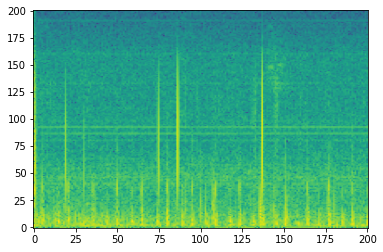

In [120]:
# display the first image and steering angle
import matplotlib.pyplot as plt
import time 
start = time.time()
x_batch, y_batch = next(batch_generator(train_audio_paths, train_labels, 32))
end = time.time()
print("Time to generate batch: ", (end - start) * 1000, "ms")
plt.imshow(x_batch[1], aspect='auto', origin='lower')

In [121]:
print(x_batch.shape)

(32, 201, 201)


In [122]:
batch_size = 32

train_gen = batch_generator(train_audio_paths, train_labels, batch_size=batch_size)
test_gen = batch_generator(test_audio_paths, test_labels, batch_size=batch_size)

In [123]:
image1, label1 = next(train_gen)
print(image1.shape)
print(label1.shape)
print(label1)

(32, 201, 201)
(32,)
[0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 1. 1. 1. 0.]


In [129]:
import keras as ks
from keras.models import Sequential
from keras.layers import Dense, InputLayer, Flatten, Conv2D

# a sequential model is a model that is made up of layers
model = Sequential()
# the input layer is the first layer in the model
model.add(InputLayer(input_shape=(201, 201, 1)))
# try modifying the number of nodes in the hidden layer to see how it affects the model
# you can also try changing the activation function to see how it affects the model
# adding more layers to the model may also help

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


In [130]:
model.compile(optimizer='adam', loss='bce', metrics=['accuracy']) # we will keep track of the mean squared error using mse
hist = model.fit(train_gen, steps_per_epoch=np.ceil(float(len(train_labels)) / float(batch_size)), validation_data=test_gen, validation_steps=25, epochs=25) # changing the number of epochs may help the model!

Epoch 1/25


ResourceExhaustedError: Graph execution error:

Detected at node 'gradient_tape/sequential_21/dense_56/MatMul/MatMul_1' defined at (most recent call last):
    File "c:\Users\arcxo\AppData\Local\Programs\Python\Python39\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\arcxo\AppData\Local\Programs\Python\Python39\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\arcxo\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "c:\Users\arcxo\AppData\Local\Programs\Python\Python39\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "c:\Users\arcxo\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "c:\Users\arcxo\AppData\Local\Programs\Python\Python39\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\arcxo\AppData\Local\Programs\Python\Python39\lib\asyncio\base_events.py", line 596, in run_forever
      self._run_once()
    File "c:\Users\arcxo\AppData\Local\Programs\Python\Python39\lib\asyncio\base_events.py", line 1890, in _run_once
      handle._run()
    File "c:\Users\arcxo\AppData\Local\Programs\Python\Python39\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\arcxo\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\kernelbase.py", line 461, in dispatch_queue
      await self.process_one()
    File "c:\Users\arcxo\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\kernelbase.py", line 450, in process_one
      await dispatch(*args)
    File "c:\Users\arcxo\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\kernelbase.py", line 357, in dispatch_shell
      await result
    File "c:\Users\arcxo\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\kernelbase.py", line 652, in execute_request
      reply_content = await reply_content
    File "c:\Users\arcxo\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\ipkernel.py", line 353, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "c:\Users\arcxo\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\arcxo\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py", line 2768, in run_cell
      result = self._run_cell(
    File "c:\Users\arcxo\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py", line 2814, in _run_cell
      return runner(coro)
    File "c:\Users\arcxo\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\arcxo\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py", line 3012, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\arcxo\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py", line 3191, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\arcxo\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py", line 3251, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\arcxo\AppData\Local\Temp\ipykernel_19288\3608613853.py", line 2, in <module>
      hist = model.fit(train_gen, steps_per_epoch=np.ceil(float(len(train_labels)) / float(batch_size)), validation_data=test_gen, validation_steps=25, epochs=25) # changing the number of epochs may help the model!
    File "c:\Users\arcxo\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\arcxo\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\arcxo\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "c:\Users\arcxo\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\arcxo\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "c:\Users\arcxo\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 893, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "c:\Users\arcxo\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 537, in minimize
      grads_and_vars = self._compute_gradients(
    File "c:\Users\arcxo\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 590, in _compute_gradients
      grads_and_vars = self._get_gradients(tape, loss, var_list, grad_loss)
    File "c:\Users\arcxo\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 471, in _get_gradients
      grads = tape.gradient(loss, var_list, grad_loss)
Node: 'gradient_tape/sequential_21/dense_56/MatMul/MatMul_1'
OOM when allocating tensor with shape[256,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradient_tape/sequential_21/dense_56/MatMul/MatMul_1}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_21485]